## Лабораторная работа №5
### Начально-краевые задачи для дифференциального уравнения параболического типа

Сорокин Никита, М8О-403Б-20

### Задание
Используя явную и неявную конечно-разностные схемы, а также схему Кранка - Николсона, решить начально-краевую задачу для дифференциального уравнения параболического типа. Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением  $ U(x, t) $.

Вариант 2:

$$
\begin{cases}

\frac{ \partial u }{ \partial t } = a^2 \frac{ \partial^2 u }{ \partial x^2} , a>0, \\
u(0, t) = 0, \\
 u(1, t) = 1, \\ 
 u(x, 0) = x + sin(\pi x)

\end{cases}

$$

Аналитическое решение: 

$$
U(x, t) = x + e^{-\pi^2 a t} sin(\pi x)
$$


In [47]:
import sys 
sys.path

sys.path.insert(0, r"c:\Users\никита\Desktop\учеба\чм\modules")

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set()

%matplotlib inline

from LinearAlgebra import *

In [49]:
a = 1

x_begin = 0
x_end = 1

t_begin = 0
t_end = 1

h = 0.1
tau = h**2 / (2 * a**2)
sigma = a**2 * tau / h**2

In [50]:
def check_sigma(sigma):
    res = True if sigma <= 1 / 2 else False
    return res

check_sigma(sigma)

True

Начальные условия:

In [51]:
def solution(x, t, a=1):
    u = x + np.exp(-np.pi**2 * a * t) * np.sin(np.pi * x)
    return u 

def phi_0(t, a=1):
    return 0

def phi_1(t, a=1):
    return 1
    
def psi(x):
    return x + np.sin(np.pi * x)

### Точное решение

Дано по условию:

In [52]:
def get_analytical_solution(x_begin, x_end, t_begin, t_end, h, tau, a):

    x = np.arange(x_begin, x_end + h, h)
    t = np.arange(t_begin, t_end + tau, tau)

    res = np.zeros((len(t), len(x)))
    for idx in range(len(x)):
        for idt in range(len(t)):
            res[idt][idx] = solution(x[idx], t[idt], a)
    
    return res

In [53]:
u_exact = get_analytical_solution(x_begin, x_end, t_begin, t_end, h, tau, a)

### Явная схема

В исходном уравнении перейдем от производных к их численным приближениям. Вторую производную будем аппроксимировать по значениям нижнего временного слоя.

$$

\frac{\mathit{u}_{\mathit{j}}^{k+1}-\mathit{u}_{\mathit{j}}^{k}}{\tau}
 = 
a^{2} \frac{ {\mathit{u}_{\mathit{j+1}}^{k}-2\mathit{u}_{\mathit{j}}^{k}+u}_{j-1}^{k}}{h^{2}}+O\! \left(h^{2}+\tau \right)

$$

Выразим $ u_j^{k+1} $ и получим:

$$ u_j^{k+1} = \sigma u_{j-1}^k + (1-2\sigma)u_j^k + \sigma u_{j+1}^k $$


где $ \sigma = \frac{a\tau}{h^2}$

In [54]:
def explicit_scheme(x_begin, x_end, t_begin, t_end, h, tau, a, phi_0, phi_1, psi):

    sigma = a**2 * tau / h**2
    x = np.arange(x_begin, x_end + h, h)
    t = np.arange(t_begin, t_end + tau, tau)
    res = np.zeros((len(t), len(x)))

    res = np.zeros((len(t), len(x)))
    for col_id in range(len(x)):
        res[0][col_id] = psi(x[col_id])

    for row_id in range(1, len(t)):
        res[row_id][0] = phi_0(t[row_id], a)
        for col_id in range(1, len(x)-1):
            res[row_id][col_id] = (
                sigma * res[row_id-1][col_id-1] 
                + (1 - 2*sigma) * res[row_id-1][col_id]
                + sigma * res[row_id-1][col_id+1]
            )

        res[row_id][-1] = phi_1(t[row_id], a)
    
    return res

In [55]:
u_explicit = explicit_scheme(x_begin, x_end, t_begin, t_end, h, tau, a, phi_0, phi_1, psi)

### Неявная схема

В исходном уравнении перейдем от производных к их численным приближениям. Вторую производную будем аппроксимировать по значениям верхнего временного слоя:

$$

\frac{\mathit{u}_{\mathit{j}}^{k+1}-\mathit{u}_{\mathit{j}}^{k}}{\tau}
 = 
a^{2} \frac{ {\mathit{u}_{\mathit{j+1}}^{k+1}-2\mathit{u}_{\mathit{j}}^{k+1}+u}_{j-1}^{k+1}}{h^{2}}+O\! \left(h^{2}+\tau \right)

$$

Выражаем $ u_{j}^{k + 1} $ и получаем СЛАУ для трехдиагональной матрицы, которую можно решать методом прогонки написанным ранее:

$$

\begin{equation*}
 \begin{cases}
   b_1u_1^{k+1}+c_1u_2^{k+1}=d_1, ~~~j=1, 
   \\
   a_ju_{j-1}^{k+1}+b_ju_j^{k+1}+c_ju_{j+1}^{k+1}=d_j, ~~~j=2\dots N-2,
   \\
   a_{N-1}u_{N-2}^{k+1}+b_{N-1}u_{N-1}^{k+1}=d_{N-1}, ~~~j=N-1.
 \end{cases}
\end{equation*}

$$

$$ 
\begin{align}
a_j &=c_j=\sigma \\
b_j &=-(1+2\sigma) \\
d_j &= -u_j^k, ~~~j=2\dots N-2 \\
d_1 &=-(u_1^k+\sigma\phi_0(t^{k+1})) \\
d_{N-1} &=-(u_{N-1}^k+\sigma\phi_1(t^{k+1})) 
\end{align}
$$


In [56]:
def implicit_scheme(x_begin, x_end, t_begin, t_end, h, tau, a, phi_0, phi_1, psi):

    sigma = a**2 * tau / h**2
    x = np.arange(x_begin, x_end + h, h)
    t = np.arange(t_begin, t_end + tau, tau)
    res = np.zeros((len(t), len(x)))

    for col_id in range(len(x)):
        res[0, col_id] = psi(x[col_id])

    for row_id in range(1, len(t)):
        A = np.zeros((len(x) - 2, len(x) - 2))

        A[0, 0] = -(1 + 2 * sigma)
        A[0, 1] = sigma
        for i in range(1, len(A) - 1):
            A[i, i-1] = sigma
            A[i, i] = -(1 + 2 * sigma)
            A[i, i+1] = sigma
        A[-1, -2] = sigma
        A[-1, -1] = -(1 + 2 * sigma)

        b = -res[row_id - 1, 1:-1]
        b[0] -= sigma * phi_0(t[row_id])
        b[-1] -= sigma * phi_1(t[row_id])

        res[row_id, 0] = phi_0(t[row_id])
        res[row_id, -1] = phi_1(t[row_id])
        res[row_id, 1:-1] = sweep_method(A, b)

    return res

In [57]:
u_implicit = implicit_scheme(x_begin, x_end, t_begin, t_end, h, tau, a, phi_0, phi_1, psi)

### Схема Кранка-Николсона

Рассмотрим неявно-явную схему с весами для простейшего уравнения теплопроводности:

$$

\frac{\mathit{u}_{\mathit{j}}^{k+1}-\mathit{u}_{\mathit{j}}^{k}}{\tau}
 = 
\theta a^{2} \frac{ {\mathit{u}_{\mathit{j+1}}^{k+1}-2\mathit{u}_{\mathit{j}}^{k+1}+u}_{j-1}^{k+1}}{h^{2}} +
(1 - \theta) a^{2} \frac{ {\mathit{u}_{\mathit{j+1}}^{k}-2\mathit{u}_{\mathit{j}}^{k}+u}_{j-1}^{k}}{h^{2}}

$$

При $\theta = \frac{1}{2}$ имеем схему Кранка-Николсона.

Аналогично неявной схеме:

$$

\begin{equation*}
 \begin{cases}
   b_1u_1^{k+1}+c_1u_2^{k+1}=d_1, ~~~j=1, 
   \\
   a_ju_{j-1}^{k+1}+b_ju_j^{k+1}+c_ju_{j+1}^{k+1}=d_j, ~~~j=2\dots N-2,
   \\
   a_{N-1}u_{N-2}^{k+1}+b_{N-1}u_{N-1}^{k+1}=d_{N-1}, ~~~j=N-1.
 \end{cases}
\end{equation*}

$$

$$

\begin{align}
a_j &= c_j=\sigma\theta \\
b_j &= -(1+2\sigma\theta) \\
d_j &= -(u_j^k+(1-\theta)\sigma(u_{j-1}^k-2u_j^k+u_{j+1}^k)), ~~~j=2\dots N-2 \\
d_1 &= -(u_1^k+\sigma\phi_0(t^{k+1}) - (1-\theta)\sigma(u_{2}^k-2u_1^k+u_{0}^k)) \\
d_{N-1} & =-(u_{N-1}^k+\sigma\phi_1(t^{k+1}) - (1-\theta)\sigma(u_{N}^k-2u_{N-1}^k+u_{N-2}^k)) \\
\end{align}
$$


Это трехдиагональная СЛАУ, которую можно решить методом прогонки.

In [58]:
def crank_nickolson_scheme(x_begin, x_end, t_begin, t_end, h, tau, a, phi_0, phi_1, psi, theta=1/2):

    sigma = a**2 * tau / h**2
    x = np.arange(x_begin, x_end + h, h)
    t = np.arange(t_begin, t_end + tau, tau)
    res = np.zeros((len(t), len(x)))

    for col_id in range(len(x)):
        res[0, col_id] = psi(x[col_id])

    for row_id in range(1, len(t)):
        A = np.zeros((len(x) - 2, len(x) - 2)) 

        A[0, 0] = -(1 + 2 * sigma * theta)
        A[0, 1] = sigma * theta
        for i in range(1, len(A) - 1):
            A[i, i - 1] = sigma * theta
            A[i, i] = -(1 + 2 * sigma * theta)
            A[i, i + 1] = sigma * theta
        A[-1, -2] = sigma * theta
        A[-1, -1] = -(1 + 2 * sigma * theta)

        b = np.array([-(res[row_id-1, i] + (1-theta) * sigma * (res[row_id-1][i-1] - 2*res[row_id-1][i] + res[row_id-1][i+1])) for i in range(1, len(res[row_id-1])-1)])
        b[0] -= sigma * theta * phi_0(t[row_id])
        b[-1] -= sigma * theta * phi_1(t[row_id])

        res[row_id, 0] = phi_0(t[row_id])
        res[row_id, -1] = phi_1(t[row_id])
        res[row_id, 1:-1] = sweep_method(A, b)

    return res

In [59]:
u_crank_nickolson = crank_nickolson_scheme(x_begin, x_end, t_begin, t_end, h, tau, a, phi_0, phi_1, psi)

### Полученные результаты


Графики:

In [60]:
u_explicit[:, 0].shape

(201,)

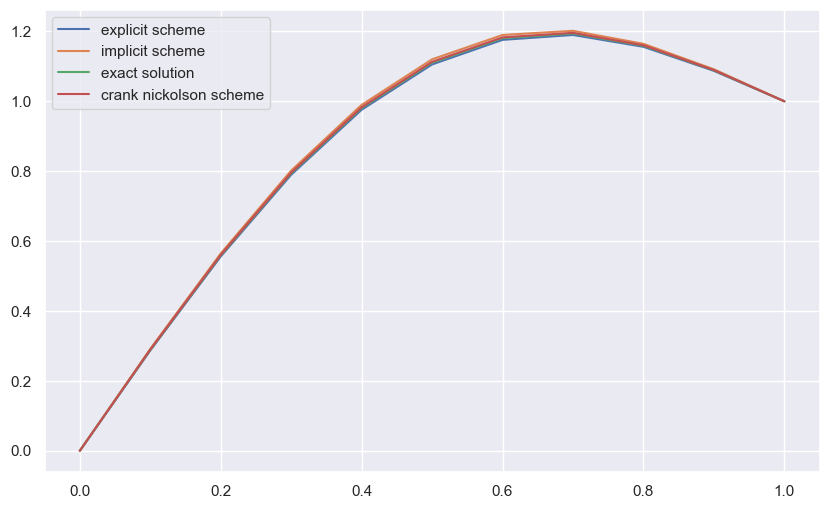

In [61]:
fig, axs = plt.subplots(figsize=(10, 6))

x = np.arange(x_begin, x_end + h, h)

i = 10
line1, = axs.plot(x, u_explicit[i, :], label="explicit scheme")
line2, = axs.plot(x, u_implicit[i, :], label="implicit scheme")
line3, = axs.plot(x, u_exact[i, :], label="exact solution")
line4, = axs.plot(x, u_crank_nickolson[i, :], label="crank nickolson scheme")

plt.legend()

Функция для вычисления погрешности - максимального модуля ошибки

In [62]:
def max_abs_error(A, B):
    assert A.shape == B.shape
    return abs(A - B).max()

И среднего модуля ошибки:

In [63]:
def mean_abs_error(A, B):
    assert A.shape == B.shape
    return abs(A - B).mean()

In [64]:
def print_errors(h=0.01):

    tau = h**2 / (2 * a**2)
    sigma = a**2 * tau / h**2

    u_exact = get_analytical_solution(x_begin, x_end, t_begin, t_end, h, tau, a)
    u_explicit = explicit_scheme(x_begin, x_end, t_begin, t_end, h, tau, a, phi_0, phi_1, psi)
    u_implicit = implicit_scheme(x_begin, x_end, t_begin, t_end, h, tau, a, phi_0, phi_1, psi)
    u_crank_nickolson = crank_nickolson_scheme(x_begin, x_end, t_begin, t_end, h, tau, a, phi_0, phi_1, psi)

    print(f'h = {h} \n')

    print(f'u_explicit mean abs error: {mean_abs_error(u_exact, u_explicit)}')
    print(f'u_explicit max abs error: {max_abs_error(u_exact, u_explicit)} \n')

    print(f'u_implicit mean abs error: {mean_abs_error(u_exact, u_implicit)}')
    print(f'u_implicit max abs error: {max_abs_error(u_exact, u_implicit)} \n')

    print(f'u_crank_nickolson mean abs error: {mean_abs_error(u_exact, u_crank_nickolson)}')
    print(f'u_crank_nickolson max abs error: {max_abs_error(u_exact, u_crank_nickolson)}')

In [65]:
h1 = 0.1
print_errors(h1)

h = 0.1 

u_explicit mean abs error: 0.0009607639976331366
u_explicit max abs error: 0.0061635046169227214 

u_implicit mean abs error: 0.0018931477373606352
u_implicit max abs error: 0.011849648722166206 

u_crank_nickolson mean abs error: 0.0004662839783366718
u_crank_nickolson max abs error: 0.0029542842651493206


In [66]:
h2 = 0.05
print_errors(h2)

h = 0.05 

u_explicit mean abs error: 0.00025227508109572084
u_explicit max abs error: 0.0015197269734945618 

u_implicit mean abs error: 0.0005026721251518475
u_implicit max abs error: 0.0030096056866816268 

u_crank_nickolson mean abs error: 0.00012520444550339287
u_crank_nickolson max abs error: 0.0007519292135637068


### Вывод

В данной работе я научился решать начально-краевые задачи для ДУ параболического типа тремя способами:
* с помощью явной конечно-разностной схемы
* с помощью неявной конечно-разностной схемы
* с помощью схемы Кранка-Николсона

С помощью каждого метода получилось решить заданное ДУ с приемлемой точностью.

В ходе работы я выявил плюсы и минусы изученных алгоритмов. 

Явная конечно-разностная схема легко считается, но она не всегда устойчива и, соответственно, не всегда гарантирует адекватный результат.

Неявная схема абсолютно устойчива, но она требует больших вычислительных затрат - приходится решать много СЛАУ. 

Схема Кранка-Николсона "комбинирует" предыдущие схемы, поэтому имеет наименьшую погрешность. Но при этом она по-прежнему использует сложные вычисления.